## Mission: Réaliser un algorithme de détection de la race d'un chien à partir de sa photo

### Notebook d'entraînement de modèles basés sur du CNN Transfer Learning.  
#### 12 races de chiens sont retenues pour la modélisation.

## Sommaire

- [Importation des librairies](#Importation-des-librairies)
- [Utilisation de Google Colab](#Google-colab)
    - Utilisation du GPU de Colab pour un temps d'exécution plus rapide
- [Préparation et Répartition des Données pour 12 races de chiens](#Prétraitement-des-données-4-races)
    - 3 ensembles distincts: entraînement, validation et test
- [Configuration des Générateurs de Données](#Configuration-des-générateurs-de-données)
    - Utilisation de ImageDataGenerator de Keras. Normalisation, rotation, zoom, retournement horizontal.
- [Transfer Learning avec VGG16](#VGG16)
    - Modélisation  
    - Entraînement du modèle  
    - Évaluation du modèle  
    - Matrice de confusion     
- [InceptionV3](#inceptionV3)  
    - Modélisation  
    - Entraînement du modèle  
    - Évaluation du modèle  
    - Matrice de confusion   
- [Comparaison des modèles](#comparaison)  
    - Sauvegarde du modèle le plus performant

## Importation des libraries<a name="importation-des-librairies"></a>

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import os
import shutil
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from math import ceil

In [24]:
print(os.listdir("/content/data_transfer_learning"))

['validation', 'train', 'test']


In [25]:
shutil.rmtree("/content/data_transfer_learning")

## Utilisation de Google Colab<a name="Google-Colab"></a>

Utilisation du GPU de Colab pour un temps d'exécution plus rapide

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Préparation et Répartition des Données<a name="Prétraitement-des-données"></a>

`Pour ne pas avoir un temps d'entraînement trop long pour le modèle, on limitera le dataset à 12 races de chiens, ce qui représente 10% du nombre total de races du dataset d'origine (120 races).`  
Script conçu pour préparer et répartir l'ensemble de données d'images de chiens en trois ensembles distincts : entraînement, validation, et test (70%, 15%, 15%). Il utilise le module `os` pour créer des dossiers de structure nécessaire et `shutil` pour copier les images dans les répertoires appropriés.


In [27]:
source_folder = '/content/drive/My Drive/races_chiens_12_224_flou_eq'

data_folders = ['data_transfer_learning/train', 'data_transfer_learning/validation', 'data_transfer_learning/test']
for folder in data_folders:
    os.makedirs(folder, exist_ok=True)
    for race in os.listdir(source_folder):
        race_path = os.path.join(source_folder, race)
        if os.path.isdir(race_path):  # Vérifier que c'est bien un dossier
            os.makedirs(os.path.join(folder, race), exist_ok=True)

# Répartition des images
train_ratio = 0.7
validation_ratio = 0.15
# proportion de test implicite, c'est le reste (0.15)

for race_folder in os.listdir(source_folder):
    race_path = os.path.join(source_folder, race_folder)
    if os.path.isdir(race_path):  # Encore une vérification pour s'assurer que c'est un dossier
        all_images = os.listdir(race_path)
        np.random.shuffle(all_images)

        train_split = int(len(all_images) * train_ratio)
        validation_split = int(len(all_images) * (train_ratio + validation_ratio))

        for i, img in enumerate(all_images):
            if i < train_split:
                dest_folder = os.path.join('data_transfer_learning/train', race_folder)
            elif i < validation_split:
                dest_folder = os.path.join('data_transfer_learning/validation', race_folder)
            else:
                dest_folder = os.path.join('data_transfer_learning/test', race_folder)

            shutil.copy(os.path.join(race_path, img), os.path.join(dest_folder, img))


In [28]:
def remove_hidden_files(start_path):
    for root, _, files in os.walk(start_path):
        for file in files:
            if file.startswith('.'):  # Recherche des fichiers cachés
                os.remove(os.path.join(root, file))

# Supprimer les fichiers cachés dans les dossiers de train, validation et test
remove_hidden_files('data_transfer_learning/train')
remove_hidden_files('data_transfer_learning/validation')
remove_hidden_files('data_transfer_learning/test')


## Configuration des Générateurs de Données<a name="Configuration-des-générateurs-de-données"></a>

- **ImageDataGenerator**: Trois instances de `ImageDataGenerator` sont créées. Pour l'ensemble d'entraînement, l'augmentation des données est appliquée pour améliorer la généralisation du modèle. Cela inclut la normalisation (rescale), la rotation (shear_range), le zoom, et le retournement horizontal des images. Pour les ensembles de validation et de test, seule la normalisation est appliquée.



In [29]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data_transfer_learning/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        'data_transfer_learning/validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'data_transfer_learning/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)


Found 1370 images belonging to 12 classes.
Found 294 images belonging to 12 classes.
Found 300 images belonging to 12 classes.


## Transfer Learning avec VGG16  

### Modélisation

Le modèle VGG16 est chargé avec des poids pré-entraînés, de plus les 4 dernières couches du modèle sont dégelées et de nouvelles couches entièrement connectées sont ajoutées pour la tâche spécifique de classification des races de chiens.


In [ ]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Gel des couches de base_model
for layer in base_model.layers:
    layer.trainable = False

# Dégel des 4 dernières couches de VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Ajout de couches personnalisées pour la classification des races de chiens
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)  # 12 races de chiens

# Création du modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


### Entraînement du modèle

Le modèle est entraîné avec les données d'entraînement, en utilisant également les données de validation pour le tuning des hyperparamètres.


In [31]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [ ]:
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[time_callback]
)

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")


Epoch 1/10
42/42 [==============================] - 23s 475ms/step - loss: 2.5479 - accuracy: 0.1106 - val_loss: 2.2071 - val_accuracy: 0.2882
Epoch 2/10
42/42 [==============================] - 23s 542ms/step - loss: 2.1907 - accuracy: 0.2459 - val_loss: 1.9408 - val_accuracy: 0.3819
Epoch 3/10
42/42 [==============================] - 21s 506ms/step - loss: 1.9107 - accuracy: 0.3520 - val_loss: 1.5855 - val_accuracy: 0.4583
Epoch 4/10
42/42 [==============================] - 22s 525ms/step - loss: 1.7200 - accuracy: 0.4238 - val_loss: 1.5249 - val_accuracy: 0.4896
Epoch 5/10
42/42 [==============================] - 21s 507ms/step - loss: 1.5246 - accuracy: 0.4746 - val_loss: 1.2999 - val_accuracy: 0.5729
Epoch 6/10
42/42 [==============================] - 22s 513ms/step - loss: 1.3951 - accuracy: 0.5329 - val_loss: 1.3252 - val_accuracy: 0.5660
Epoch 7/10
42/42 [==============================] - 20s 472ms/step - loss: 1.2733 - accuracy: 0.5822 - val_loss: 1.3696 - val_accuracy: 0.5625

In [ ]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_vgg16 = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_vgg16} secondes")

Temps d'entraînement moyen : 21.508938217163085 secondes
Temps d'entraînement total : 215.08938217163086 secondes


## Évaluation du modèle

L'accuracy du modèle est calculée sur l'ensemble de test, et une matrice de confusion ainsi qu'un rapport de classification sont générés pour une analyse plus détaillée des performances du modèle.

Les noms des classes dans classification_report correspondent aux races de chiens.

In [ ]:

test_loss, vgg16_accuracy = model.evaluate(test_generator)
print('Test Accuracy:', vgg16_accuracy)

# Nombre de pas pour la prédiction
test_steps = ceil(test_generator.samples / test_generator.batch_size)

# Réinitialiser le générateur de test et faire les prédictions
test_generator.reset()
predictions = model.predict(test_generator, steps=test_steps)

# classes prédites
predicted_classes = np.argmax(predictions, axis=1)

# s'ssurer que la longueur de predicted_classes correspond à celle de true_classes
predicted_classes = predicted_classes[:len(test_generator.classes)]

# vraies classes
true_classes = test_generator.classes

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(true_classes, predicted_classes))
print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))


10/10 [==============================] - 1s 133ms/step - loss: 1.1442 - accuracy: 0.6233
Test Accuracy: 0.6233333349227905
10/10 [==============================] - 1s 139ms/step
[[17  2  2  0  1  1  0  0  0  3  0  1]
 [ 1 21  1  2  0  0  0  0  0  3  0  1]
 [ 1  5 12  1  0  0  0  0  1  2  0  3]
 [ 0  2  1 17  0  2  2  0  0  0  0  0]
 [ 2  1  3  1 11  2  1  0  1  0  0  1]
 [ 0  2  1  2  2 15  1  0  0  0  1  0]
 [ 0  1  0  1  0  2 16  0  1  0  0  2]
 [ 2  0  1  0  0  0  0 15  5  0  0  0]
 [ 0  2  4  2  0  1  0  1 12  0  0  1]
 [ 1  0  7  1  0  1  0  0  0 11  0  3]
 [ 6  0  2  0  0  3  0  0  0  0 15  0]
 [ 0  1  0  3  0  0  0  0  0  0  0 25]]
                                          precision    recall  f1-score   support

                        n02088238-basset       0.57      0.63      0.60        27
                  n02091244-Ibizan_hound       0.57      0.72      0.64        29
n02093428-American_Staffordshire_terrier       0.35      0.48      0.41        25
            n02097209-st

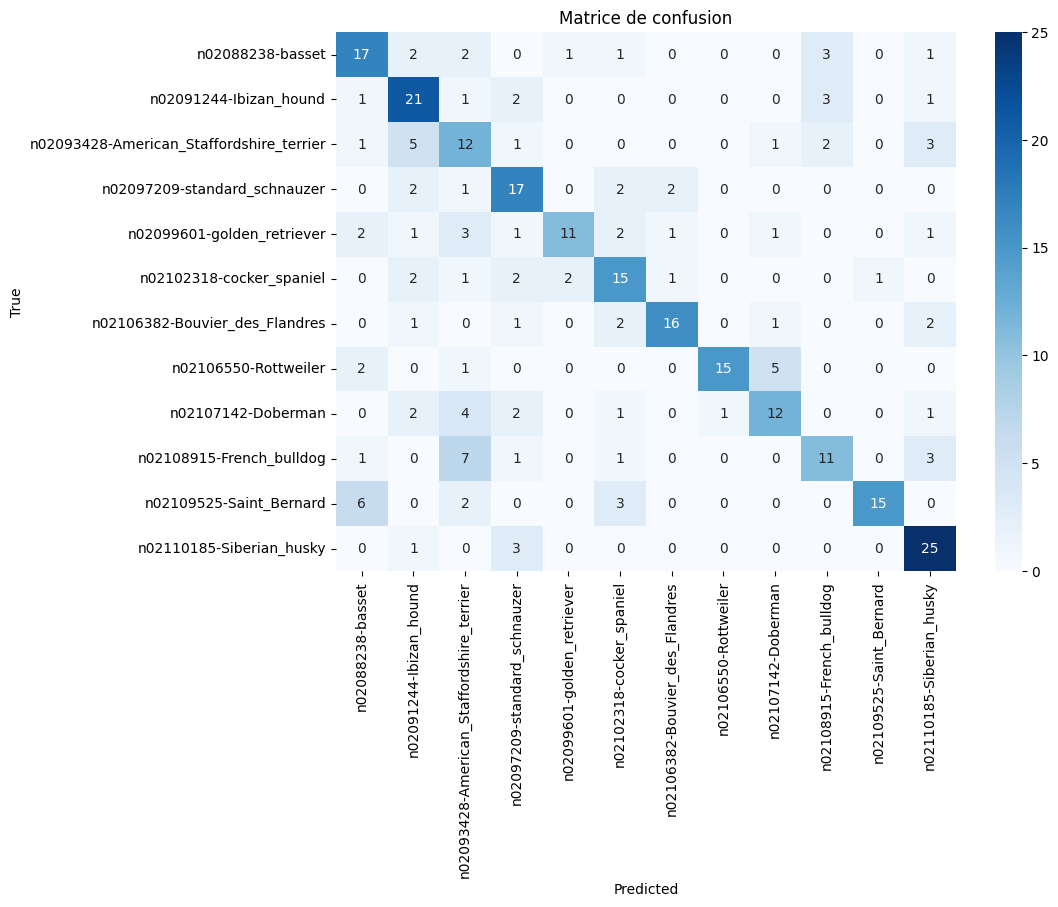

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Calcul de la matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)

class_names = list(test_generator.class_indices.keys())

# heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()


## InceptionV3

### Modélisation

In [42]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger InceptionV3 pré-entraîné sans les couches supérieures
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Geler les couches de base_model
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(12, activation='softmax')(x)  # 12 races de chiens

model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data_transfer_learning/train',
        target_size=(299, 299),  # Taille pour InceptionV3
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        'data_transfer_learning/validation',
        target_size=(299, 299),  # Taille pour InceptionV3
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'data_transfer_learning/test',
        target_size=(299, 299),  # Taille pour InceptionV3
        batch_size=32,
        class_mode='categorical',
        shuffle=False)


Found 1370 images belonging to 12 classes.
Found 294 images belonging to 12 classes.
Found 300 images belonging to 12 classes.


### Entraînement du modèle

In [44]:
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[time_callback]
)

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")


Epoch 1/10
42/42 [==============================] - 45s 970ms/step - loss: 1.7649 - accuracy: 0.5404 - val_loss: 0.8523 - val_accuracy: 0.8993
Epoch 2/10
42/42 [==============================] - 34s 821ms/step - loss: 0.7995 - accuracy: 0.8229 - val_loss: 0.3850 - val_accuracy: 0.9167
Epoch 3/10
42/42 [==============================] - 34s 810ms/step - loss: 0.5747 - accuracy: 0.8303 - val_loss: 0.2799 - val_accuracy: 0.9340
Epoch 4/10
42/42 [==============================] - 33s 797ms/step - loss: 0.4872 - accuracy: 0.8543 - val_loss: 0.2269 - val_accuracy: 0.9444
Epoch 5/10
42/42 [==============================] - 35s 828ms/step - loss: 0.4465 - accuracy: 0.8580 - val_loss: 0.2316 - val_accuracy: 0.9375
Epoch 6/10
42/42 [==============================] - 35s 824ms/step - loss: 0.4467 - accuracy: 0.8655 - val_loss: 0.2159 - val_accuracy: 0.9375
Epoch 7/10
42/42 [==============================] - 34s 807ms/step - loss: 0.3960 - accuracy: 0.8767 - val_loss: 0.2105 - val_accuracy: 0.9410

In [45]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
total_training_time = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {total_training_time} secondes")

Temps d'entraînement moyen : 35.84676601886749 secondes
Temps d'entraînement total : 358.4676601886749 secondes


### Évaluation du modèle

In [46]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Accuracy:', test_accuracy)

test_steps = ceil(test_generator.samples / test_generator.batch_size)

test_generator.reset()
predictions = model.predict(test_generator, steps=test_steps)

predicted_classes = np.argmax(predictions, axis=1)

predicted_classes = predicted_classes[:len(test_generator.classes)]

true_classes = test_generator.classes

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(true_classes, predicted_classes))
print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))


10/10 [==============================] - 4s 440ms/step - loss: 0.3029 - accuracy: 0.9033
Test Accuracy: 0.903333306312561
10/10 [==============================] - 3s 139ms/step
[[26  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 29  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  0  0  2  1  0  1]
 [ 0  0  1 21  0  0  0  0  0  0  0  2]
 [ 1  0  1  0 18  3  0  0  0  0  0  0]
 [ 1  0  0  0  0 23  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 22  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 20  2  0  0  0]
 [ 0  0  1  0  0  0  0  3 18  1  0  0]
 [ 2  0  1  0  0  0  0  0  0 20  0  1]
 [ 0  0  0  0  0  0  0  0  0  0 26  0]
 [ 1  0  1  0  0  0  0  0  0  0  0 27]]
                                          precision    recall  f1-score   support

                        n02088238-basset       0.84      0.96      0.90        27
                  n02091244-Ibizan_hound       1.00      1.00      1.00        29
n02093428-American_Staffordshire_terrier       0.81      0.84      0.82        25
            n02097209-sta

### Matrice de confusion

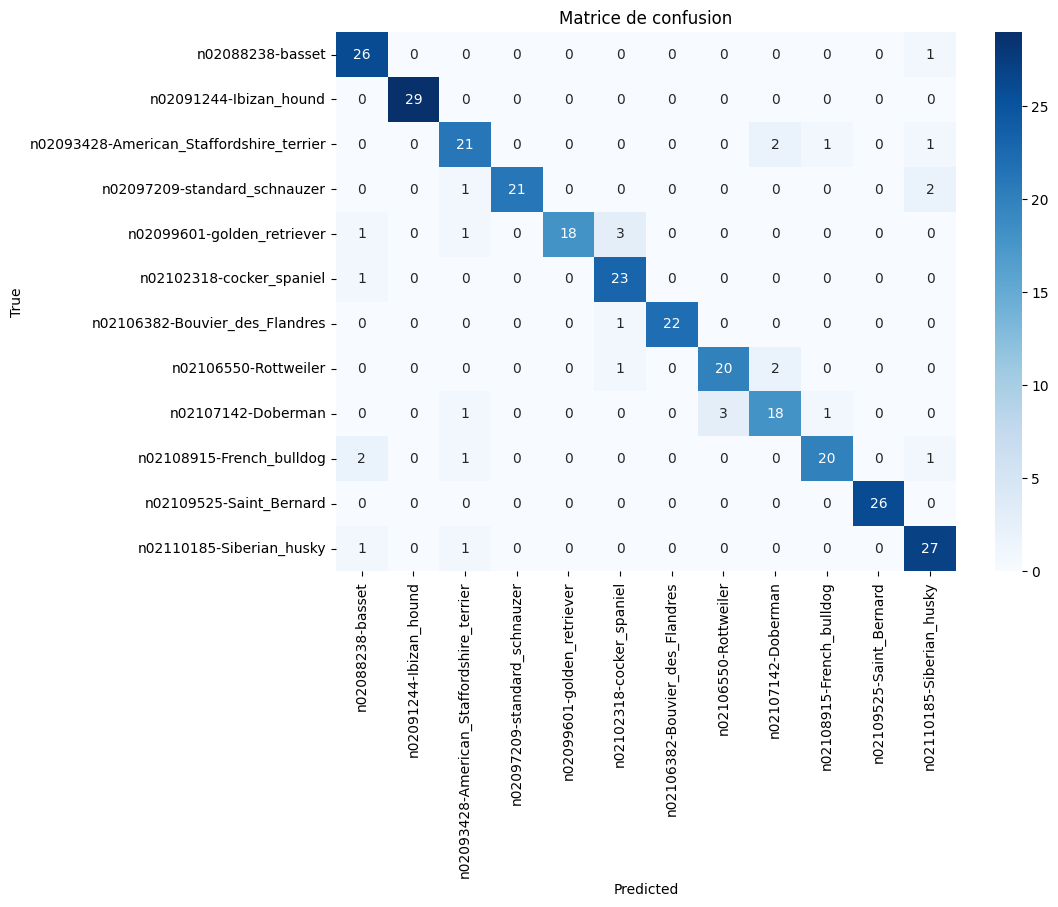

In [47]:
cm = confusion_matrix(true_classes, predicted_classes)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()


## Comparaison des modèles 

Le modèle le plus performant est le modèle InceptionV3 avec une accuracy de 0,9.  
La matrice de confusion confirme le haut niveau de prédictions correctes. Le nombre de confusions le plus important entre 2 races différentes y est de 3: confusion entre le golden retriever et le coker spaniel, ou encore confusion entre le rottweiler et le doberman.  
`InceptionV3 sera le modèle que l'on sauvegardera et que l'on exportera pour le notebook de prédiction de race d'un chien en fonction de sa photo.`

In [48]:
model.save('models/modele_inceptionv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
